## CONTEXTE

HéloGlow va bientôt ouvrir un nouveau point de vente dans un centre commercial.
Nous avons accès à des données sur les clients de ce centre commercial (un dataset Kaggle disponible ici : https://www.kaggle.com/datasets/abdallahwagih/mall-customers-segmentation).

Variables : 
- **CustomerID** : Un identifiant unique pour chaque client (integer).
- **Gender** : Le genre du client (Male/Female).
- **Age** : L'âge du client (integer).
- **Annual Income (k$)** : Le revenu annuel du client en milliers de dollars (integer).
- **Spending Score (1-100)** : Un score basé sur le comportement et les habitudes de dépenses du client (integer). Plus il est élevé, plus le client est un gros acheteur.

Nous souhaitons créer des clusters de clients afin de mieux comprendre notre future potentielle clientèle.
Ainsi, nous serons en mesure d'optimiser l’assortiment, d'activer les bons leviers marketing et de personnaliser la communication auprès des cibles.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## 1) VÉRIFICATION DES DONNÉES

In [2]:
data = pd.read_csv('Mall_Customers.csv',header=0,index_col=False,sep=',',
names = ["CUSTOMER_ID","GENDER","AGE","ANNUAL_INCOME","SPENDING_SCORE"])
# On renomme les colonnes pour enlever les espaces et les caractères spéciaux

In [3]:
data.head()
# Aperçu des données

,CUSTOMER_ID,GENDER,AGE,ANNUAL_INCOME,SPENDING_SCORE
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data.shape
# Pour connaître le nombre de lignes et de colonnes

(200, 5)

In [5]:
data.dtypes
# Pour connaître le type de données de chaque colonne

CUSTOMER_ID        int64
GENDER            object
AGE                int64
ANNUAL_INCOME      int64
SPENDING_SCORE     int64
dtype: object

In [6]:
stats = data.describe(include="all")
stats
# Pour avoir un résumé statistique du dataframe

,CUSTOMER_ID,GENDER,AGE,ANNUAL_INCOME,SPENDING_SCORE
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


On voit qu'il n'y a pas de données manquantes.

Les données sont cohérentes :
- Le genre du client prend bien deux modalités.
- L'âge s'étend de 18 à 70 ans, avec une moyenne à 39 ans.
- Les montants de revenu annuel sont vraisemblables.

In [7]:
data[['CUSTOMER_ID']].nunique()
# On vérifie qu'il n'y a pas de client en doublon

CUSTOMER_ID    200
dtype: int64

Il n'y a pas de doublon dans les clients puisque le nombre de valeurs uniques est égal au nombre total de lignes.

## 2) PRÉPARATION DES DONNÉES

GENDER est une variable catégorielle, il faut la transformer en colonne numérique.

In [8]:
# On crée la colonne FEMALE qui prend la valeur 1 si le client est une femme et sinon prend la valeur 0.
data['FEMALE'] = data['GENDER'].apply(lambda x: 1 if x == 'Female' else 0)
# On supprime la colonne GENDER
data.drop('GENDER', axis=1, inplace=True)

On veut créer des tranches de Spending score.

In [9]:
data["SPENDING_SCORE_BRACKET"] = '0-33'
data.loc[data['SPENDING_SCORE'] >= 33, 'SPENDING_SCORE_BRACKET'] = '33-66'
data.loc[data['SPENDING_SCORE'] >= 66, 'SPENDING_SCORE_BRACKET'] = '66-100'
data['SPENDING_SCORE_BRACKET'] = data['SPENDING_SCORE_BRACKET'].astype('category')
data['SPENDING_SCORE_BRACKET'].describe()

count       200
unique        3
top       33-66
freq         93
Name: SPENDING_SCORE_BRACKET, dtype: object

In [10]:
data.head()

,CUSTOMER_ID,AGE,ANNUAL_INCOME,SPENDING_SCORE,FEMALE,SPENDING_SCORE_BRACKET
0,1,19,15,39,0,33-66
1,2,21,15,81,0,66-100
2,3,20,16,6,1,0-33
3,4,23,16,77,1,66-100
4,5,31,17,40,1,33-66


## 3) RÉDUCTION DE DIMENSIONS AVEC L'ACP

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
# CUSTOMER_ID et SPENDING_SCORE_BRACKET ne sont pas des variables que l'on va projeter
X = data.drop(["CUSTOMER_ID","SPENDING_SCORE_BRACKET"],axis=1)

In [13]:
# On écrase et on standardise
X = StandardScaler().fit_transform(X)

In [14]:
# Calcul ACP avec autant de composants que de colonnes (avant de limiter le nombre de composants càd dimensions)
pca_data = PCA(n_components=X.shape[1])
pca_data.fit(X)
CP_data = pca_data.transform(X)
# On projette les clients sur les nouvelles dimensions

In [15]:
# Les nouveaux axes pour le premier client
CP_data[0]

array([-0.40638272, -0.52071363, -2.07252663,  1.33552903])

In [16]:
print(np.cumsum(np.round(pca_data.explained_variance_ratio_, decimals=4)*100))

[ 33.69  59.92  83.18 100.  ]


2 composantes expliquent 60% de la variance des données.

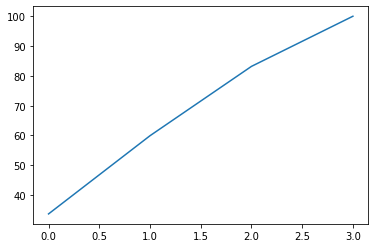

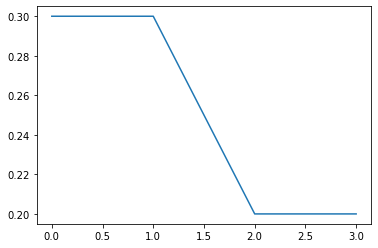

In [17]:
plt.plot(np.cumsum(np.round(pca_data.explained_variance_ratio_, decimals=4)*100))
plt.figure()
plt.plot(np.round(pca_data.explained_variance_ratio_, decimals=1))
# arrondi à 1 pour avoir une courbe "à paliers"

Le Scree plot permet de déterminer le nombre d'axes à retenir.

Le choix du nombre d'axes à retenir est un compromis entre :
- La réduction de la dimensionnalité : réduire le nombre de variables pour simplifier l'analyse.
- La conservation de l'information : ne pas perdre trop d'information en éliminant des axes.

Ici, le "coude" se situe autour du deuxième axe, ce qui signifie que les deux premiers axes expliquent une part importante de la variance et doivent donc être conservés.

In [18]:
# On conserve uniquement 2 axes et on fait le rapprochement avec les tranches de Spending score
finalDf = pd.concat([pd.DataFrame(CP_data[:,0:2], columns = ['CP1','CP2']), data[["SPENDING_SCORE",'SPENDING_SCORE_BRACKET']]], axis = 1)
finalDf.head()

,CP1,CP2,SPENDING_SCORE,SPENDING_SCORE_BRACKET
0,-0.406383,-0.520714,39,33-66
1,-1.427673,-0.367310,81,66-100
2,0.050761,-1.894068,6,0-33
3,-1.694513,-1.631908,77,66-100
4,-0.313108,-1.810483,40,33-66


In [19]:
import seaborn as sns

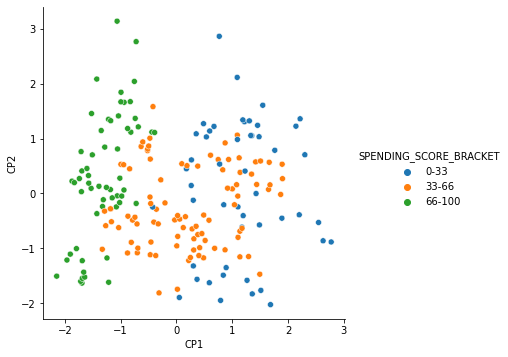

In [20]:
# On crée un scatter plot coloré en fonction de SPENDING_SCORE_BRACKET
sns.pairplot(x_vars='CP1', y_vars='CP2', data=finalDf, hue='SPENDING_SCORE_BRACKET', height=5)

On veut pouvoir interpréter les axes.

<AxesSubplot:>

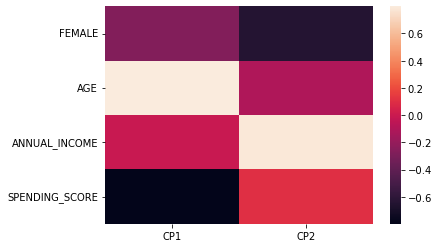

In [21]:
analyse = pd.concat([pd.DataFrame(CP_data[:,0:2], columns = ['CP1', 'CP2']), data[["FEMALE","AGE","ANNUAL_INCOME","SPENDING_SCORE"]]], axis = 1)
corr = analyse.corr().loc[["FEMALE","AGE","ANNUAL_INCOME","SPENDING_SCORE"],["CP1","CP2"]]
plt.figure()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.index.values)

In [22]:
corr

,CP1,CP2
FEMALE,-0.271992,-0.642130
AGE,0.798558,-0.106211
ANNUAL_INCOME,-0.007061,0.783861
SPENDING_SCORE,-0.797420,0.105721


CP1 (première composante principale) :
- L'âge est fortement corrélé positivement avec CP1, c'est une variable importante pour définir cet axe.
- Le score de dépenses est fortement corrélé négativement avec CP1.

Cela indique que cet axe oppose les individus ayant un âge élevé à ceux ayant un score de dépenses élevé.

CP2 (deuxième composante principale) :
- Le revenu annuel est fortement corrélé positivement avec CP2.
- Le fait d'être une femme est corrélé négativement avec CP2.

CP2 peut donc refléter une opposition entre des femmes et des clients avec un revenu annuel élevé.

## 4) CLUSTERING MIXTE

In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy import cluster
from sklearn.cluster import AgglomerativeClustering

In [24]:
# On fait une K-means avec de nombreux clusters et on récupère les coordonnées des centroïdes
# Pour le nombre idéal de clusters, une bonne pratique est de choisir n^(1/3)(limite de Wong)
k_means_cent = KMeans(n_clusters = round(len(X)**(1/3)), random_state = 2016).fit(CP_data[:,0:2])

In [25]:
# Barycentres des clusters issus de la partition K-means
centroides = k_means_cent.cluster_centers_
print(centroides)

[[-1.45816434 -1.27278647]
 [ 1.52404289 -0.73756539]
 [-1.14541787 -0.01586025]
 [ 1.09506491  0.81618921]
 [ 0.22959783 -0.95859854]
 [-0.84419574  1.37182571]]


In [26]:
finalDf['K_means_cluster'] = k_means_cent.labels_

In [27]:
# Nombre de clients dans chaque cluster
pd.crosstab(finalDf['K_means_cluster'], finalDf['SPENDING_SCORE_BRACKET'])

SPENDING_SCORE_BRACKET,0-33,33-66,66-100
K_means_cluster,,,
0,0,5,12
1,15,10,0
2,1,17,25
3,25,22,0
4,8,31,0
5,0,8,21


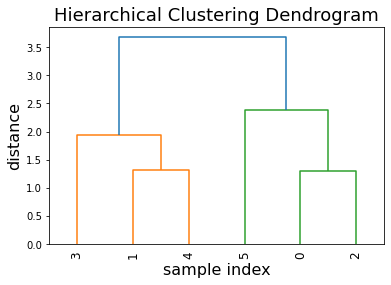

In [28]:
# On crée 6 "individus fictifs" (barycentres des clusters)
# On trace un dendogramme pour représenter cela visuellement
Z = cluster.hierarchy.linkage(centroides, method='ward', metric='euclidean')

plt.figure()
plt.title('Hierarchical Clustering Dendrogram', fontsize=18)
plt.xlabel('sample index', fontsize=16)
plt.ylabel('distance', fontsize=16)
dn = cluster.hierarchy.dendrogram(Z, leaf_font_size=12, leaf_rotation=90.)

In [29]:
# On va maintenant limiter le nombre de clusters à 3 en "coupant" le dendogramme
# On fait ainsi un HAC (Hierarchical Agglomerative Clustering)
hac_cent = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hac_cent.fit(centroides)

AgglomerativeClustering(n_clusters=3)

On récupère pour chaque client le cluster assigné lors du K-means.

In [30]:
kmeans_cent_df = pd.DataFrame(k_means_cent.labels_, columns = ['K-means_cent']).reset_index()
kmeans_cent_df

,index,K-means_cent
0,0,4
1,1,2
2,2,4
3,3,0
4,4,4
...,...,...
195,195,5
196,196,3
197,197,5
198,198,3


In [31]:
# Nombre de clients dans chaque cluster
kmeans_cent_df['K-means_cent'].value_counts()

3    47
2    43
4    39
5    29
1    25
0    17
Name: K-means_cent, dtype: int64

In [32]:
# Part de clients dans chaque cluster
kmeans_cent_df['K-means_cent'].value_counts(normalize=True)

3    0.235
2    0.215
4    0.195
5    0.145
1    0.125
0    0.085
Name: K-means_cent, dtype: float64

On récupère pour chaque client le cluster assigné lors de l'HAC.

In [33]:
hac_cent_df = pd.DataFrame(hac_cent.labels_, columns = ['Typologie']).reset_index()
hac_cent_df.sort_values(['Typologie'])

,index,Typologie
1,1,0
3,3,0
4,4,0
0,0,1
2,2,1
5,5,2


In [34]:
cluster_cent = pd.merge(kmeans_cent_df, hac_cent_df, left_on=['K-means_cent'], right_on=['index'], how='left')
cluster_cent = cluster_cent.drop(['K-means_cent','index_y'], axis =1)

In [35]:
# Nombre et part de clients dans chaque cluster
print(cluster_cent['Typologie'].value_counts())
print(cluster_cent['Typologie'].value_counts(normalize=True))

0    111
1     60
2     29
Name: Typologie, dtype: int64
0    0.555
1    0.300
2    0.145
Name: Typologie, dtype: float64


In [36]:
# Jointure finale
typologie = pd.merge(left=data, right=cluster_cent, how='inner', left_index=True, right_index=True)
typologie.head()

,CUSTOMER_ID,AGE,ANNUAL_INCOME,SPENDING_SCORE,FEMALE,SPENDING_SCORE_BRACKET,index_x,Typologie
0,1,19,15,39,0,33-66,0,0
1,2,21,15,81,0,66-100,1,1
2,3,20,16,6,1,0-33,2,0
3,4,23,16,77,1,66-100,3,1
4,5,31,17,40,1,33-66,4,0


## 5) PORTRAITS-ROBOTS

In [37]:
# Pour chaque cluster, on calcule la moyenne des variables quantitatives.
# Des "portraits-robots" vont ainsi se préciser.
# Voici le portrait-robot de la classification mixte :

stats = typologie.groupby(['Typologie'])[["FEMALE","AGE","ANNUAL_INCOME","SPENDING_SCORE"]].mean()
stats.T

Typologie,0,1,2
FEMALE,0.540541,0.800000,0.137931
AGE,47.441441,26.733333,31.034483
ANNUAL_INCOME,58.855856,52.416667,83.931034
SPENDING_SCORE,33.180180,69.866667,74.655172


- 1er cluster : clientèle plus âgée, peu dépensière

- 2e cluster : clientèle très féminine, avec un âge et un revenu annuel plus bas

- 3e cluster : clientèle très masculine, au revenu annuel très élevé

Au regard de nos ambitions et de notre stratégie d'entreprise, il est plus pertinent de cibler les 2e et 3e clusters, le 1er cluster étant moins attractif en termes de dépenses potentielles.

HéloGlow étant une entreprise de cosmétiques, nous nous adresserons principalement au 2e cluster (plus féminin). Nous pourrons également proposer une offre complémentaire ciblant les hommes au pouvoir d'achat élevé.